In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving KDDTrain.csv to KDDTrain.csv


In [ ]:
import io
training_df = pd.read_csv(io.BytesIO(uploaded['KDDTrain.csv']))

In [ ]:
uploaded = files.upload()

Saving KDDTest.csv to KDDTest.csv


In [ ]:
testing_df = pd.read_csv(io.BytesIO(uploaded['KDDTest.csv']))

In [ ]:
training_dfn=training_df
testing_dfn=testing_df

In [ ]:
training_dfn.replace('?', np.nan, inplace=True)
training_dfn.dropna(inplace=True)
testing_dfn.replace('?', np.nan, inplace=True)
testing_dfn.dropna(inplace=True)

In [ ]:
testing_dfn.head()


duration  protocol_type  ...  dst_host_srv_rerror_rate  xAttack
0         0              1  ...                      1.00        1
1         0              1  ...                      1.00        1
2         2              1  ...                      0.00        0
3         0              2  ...                      0.00        1
4         1              1  ...                      0.71        1

[5 rows x 42 columns]

In [ ]:
x,Y=training_dfn,training_dfn.pop("xAttack").values
X=x.values
x_test,C=testing_dfn,testing_dfn.pop("xAttack").values
T=x_test.values

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
trainX = scaler.transform(X)
scaler.fit(T)
testT = scaler.transform(T)

In [ ]:
y0=np.ones(len(Y),np.int8)
y0[np.where(Y==0)]=0
y0_test=np.ones(len(C),np.int8)
y0_test[np.where(C==0)]=0

In [ ]:
###########################################################Stacked Autencoder ##################################################3

In [ ]:
# Stacked Autoencoder 
from keras import models
from keras import layers
def create_stack_network():
  inputs = Input(shape=(41,))
  encoded = Dense(41, activation='tanh')(inputs)
  encoded = Dense(32, activation='tanh')(encoded)
  encoded = Dense(24, activation='tanh')(encoded)
    
  encoded = Dense(16, activation='tanh')(encoded)

  decoded = Dense(24, activation='tanh')(encoded)
  decoded = Dense(32, activation='tanh')(decoded)
  decoded = Dense(41, activation='tanh')(decoded)
  autoencoder=Model(inputs,decoded)
  autoencoder.compile(optimizer='adam',loss='mean_squared_error')
  return autoencoder

In [ ]:
from sklearn.model_selection import KFold

n_split=3
cvscores = []
hist=[]
NtrainX=trainX[np.where(y0==0)]
for train_index,test_index in KFold(n_split).split(NtrainX):
  x_train,x_test=NtrainX[train_index],NtrainX[test_index]
  model=create_stack_network()
  history=model.fit(x_train, x_train,validation_data=[testT,testT], epochs=20,batch_size=128)
  hist.append(history)
  scores = model.evaluate(testT, testT)
  cvscores.append(scores * 100)
  print(". : %.2f%%" % (scores*100))

Train on 44895 samples, validate on 22543 samples
Epoch 1/20
44895/44895 [==============================] - 1s 20us/sample - loss: 0.0162 - val_loss: 0.0241
Epoch 2/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0042 - val_loss: 0.0161
Epoch 3/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0025 - val_loss: 0.0129
Epoch 4/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0019 - val_loss: 0.0120
Epoch 5/20
44895/44895 [==============================] - 1s 19us/sample - loss: 0.0016 - val_loss: 0.0112
Epoch 6/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0015 - val_loss: 0.0107
Epoch 7/20
44895/44895 [==============================] - 1s 17us/sample - loss: 0.0014 - val_loss: 0.0104
Epoch 8/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0013 - val_loss: 0.0111
Epoch 9/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0012 - val_

In [ ]:
####################################################Sparse Autoencocer ###################################################3

In [ ]:
# Sparse Autoencoder 
from keras import models
from keras import layers
from keras import regularizers

def create_sparse_network():
  inputs = Input(shape=(41,))
  encoded = Dense(41, activation='tanh',activity_regularizer=regularizers.l1(10e-6))(inputs)
  encoded = Dense(32, activation='tanh',activity_regularizer=regularizers.l1(10e-6))(encoded)
  encoded = Dense(24, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(encoded)
  encoded = Dense(16, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(encoded)

  decoded = Dense(24, activation='tanh')(encoded)
  decoded = Dense(32, activation='tanh')(decoded)
  decoded = Dense(41, activation='tanh')(decoded)
  autoencoder=Model(inputs,decoded)
  autoencoder.compile(optimizer='adam',loss='mean_squared_error')
  return autoencoder

In [ ]:
from sklearn.model_selection import KFold

n_split=3
cvscores = []
hist=[]
NtrainX=trainX[np.where(y0==0)]
for train_index,test_index in KFold(n_split).split(NtrainX):
  x_train,x_test=NtrainX[train_index],NtrainX[test_index]
  model=create_sparse_network()
  history=model.fit(x_train, x_train,validation_data=[testT,testT], epochs=20,batch_size=128)
  hist.append(history)
  scores = model.evaluate(testT, testT)
  cvscores.append(scores * 100)
  print(". : %.2f%%" % (scores*100))
 


Train on 44895 samples, validate on 22543 samples
Epoch 1/20
44895/44895 [==============================] - 1s 28us/sample - loss: 0.0180 - val_loss: 0.0276
Epoch 2/20
44895/44895 [==============================] - 1s 26us/sample - loss: 0.0051 - val_loss: 0.0195
Epoch 3/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0035 - val_loss: 0.0156
Epoch 4/20
44895/44895 [==============================] - 1s 19us/sample - loss: 0.0028 - val_loss: 0.0128
Epoch 5/20
44895/44895 [==============================] - 1s 23us/sample - loss: 0.0024 - val_loss: 0.0106
Epoch 6/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0021 - val_loss: 0.0094
Epoch 7/20
44895/44895 [==============================] - 1s 23us/sample - loss: 0.0019 - val_loss: 0.0085
Epoch 8/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0018 - val_loss: 0.0085
Epoch 9/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0017 - val_

In [ ]:
######################################################Denoising Autoencoder###############################################

In [ ]:
#Denoising Autoencoder
noise_factor = 0.1
x_train_noisy = trainX + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=trainX.shape)
x_test_noisy = testT + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=testT.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [ ]:
from sklearn.model_selection import KFold

n_split=3
cvscores = []
hist=[]
NtrainX=trainX[np.where(y0==0)]
NtrainX_noisy=x_train_noisy[np.where(y0==0)]

for train_index,test_index in KFold(n_split).split(NtrainX):
  x_train,x_test=NtrainX[train_index],NtrainX[test_index]
  x_train_noisy2=NtrainX_noisy[train_index]
  model=create_stack_network()
  history=model.fit(x_train_noisy2, x_train,validation_data=[x_test_noisy,testT], epochs=20,batch_size=128)
  hist.append(history)
  scores = model.evaluate(testT, testT)
  cvscores.append(scores * 100)
  print(". : %.2f%%" % (scores*100))

Train on 44895 samples, validate on 22543 samples
Epoch 1/20
44895/44895 [==============================] - 2s 34us/sample - loss: 0.0182 - val_loss: 0.0282
Epoch 2/20
44895/44895 [==============================] - 1s 26us/sample - loss: 0.0058 - val_loss: 0.0193
Epoch 3/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0042 - val_loss: 0.0153
Epoch 4/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0037 - val_loss: 0.0139
Epoch 5/20
44895/44895 [==============================] - 1s 25us/sample - loss: 0.0033 - val_loss: 0.0133
Epoch 6/20
44895/44895 [==============================] - 1s 25us/sample - loss: 0.0030 - val_loss: 0.0128
Epoch 7/20
44895/44895 [==============================] - 1s 25us/sample - loss: 0.0028 - val_loss: 0.0124
Epoch 8/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0026 - val_loss: 0.0119
Epoch 9/20
44895/44895 [==============================] - 1s 24us/sample - loss: 0.0024 - val_

In [ ]:
#####################Contractive Autoencoder ########################

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
from sklearn.model_selection import KFold
lam = 1e-5

session = tf.compat.v1.keras.backend.get_session()

tf.compat.v1.disable_eager_execution()


tfd = tfp.distributions

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)   

inputs = Input(shape=(41,))
encoded = Dense(41, activation='tanh')(inputs)
encoded = Dense(32, activation='tanh')(encoded)
encoded = Dense(24, activation='tanh')(encoded)
   
encoded = Dense(16, activation='tanh',name='encoded')(encoded)

decoded = Dense(24, activation='tanh')(encoded)
decoded = Dense(32, activation='tanh')(decoded)
decoded = Dense(41, activation='tanh')(decoded)
model=Model(inputs,decoded)

def contractive_loss(y_pred, y_true):
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=model.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = model.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive

model.compile(optimizer='adam',loss=contractive_loss)
n_split=3
cvscores = []
hist=[]

NtrainX=trainX[np.where(y0==0)]

for train_index,test_index in KFold(n_split).split(NtrainX):
  x_train,x_test=NtrainX[train_index],NtrainX[test_index]

  history=model.fit(x_train, x_train,validation_data=[testT,testT],epochs=20,batch_size=128)
  hist.append(history)
  scores = model.evaluate(testT, testT)
  cvscores.append(scores * 100)
  print(". : %.2f%%" % (scores*100))
  

Train on 44895 samples, validate on 22543 samples
Epoch 1/20
44895/44895 [==============================] - ETA: 0s - loss: 0.0185WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
44895/44895 [==============================] - 1s 19us/sample - loss: 0.0185 - val_loss: 0.0243
Epoch 2/20
44895/44895 [==============================] - 1s 19us/sample - loss: 0.0048 - val_loss: 0.0161
Epoch 3/20
44895/44895 [==============================] - 1s 19us/sample - loss: 0.0028 - val_loss: 0.0130
Epoch 4/20
44895/44895 [==============================] - 1s 18us/sample - loss: 0.0021 - val_loss: 0.0107
Epoch 5/20
44895/44895 [==============================] - 1s 20us/sample - loss: 0.0017 - val_loss:

In [ ]:
##############################################################Convolutional Autoencoder################################################

In [ ]:
#convolutional autoenoder


from keras.engine.topology import Layer
from keras.models import Sequential
import keras.backend as K
from keras.layers import Conv2DTranspose,BatchNormalization,Dropout, Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Activation, Lambda, Reshape, Flatten

class Conv1DTranspose(Layer):
    def __init__(self, filters, kernel_size, strides=1, *args, **kwargs):
        self._filters = filters
        self._kernel_size = (1, kernel_size)
        self._strides = (1, strides)
        self._args, self._kwargs = args, kwargs
        super(Conv1DTranspose, self).__init__()

    def build(self, input_shape):
        print("build", input_shape)
        self._model = Sequential()
        self._model.add(Lambda(lambda x: K.expand_dims(x,axis=1), batch_input_shape=input_shape))
        self._model.add(Conv2DTranspose(self._filters,
                                        kernel_size=self._kernel_size,
                                        strides=self._strides,
                                        *self._args, **self._kwargs))
        self._model.add(Lambda(lambda x: x[:,0]))
        self._model.summary()
        super(Conv1DTranspose, self).build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)



from numpy import zeros, newaxis
xin=trainX[:,:,newaxis]
xin_test=testT[:,:,newaxis]
xin.shape


def create_Convolutional_network():
	inp = Input(shape=(xin.shape[1],1))
	conv1 = Conv1D(8, 3, activation='tanh', padding='same')(inp) #41
	conv1 = BatchNormalization()(conv1)
	conv1 = MaxPooling1D(2)(conv1)
	conv7b = Conv1D(8, 3, activation='tanh', padding='same')(conv1)
	conv7b = BatchNormalization()(conv7b)     
 

	conv7b = UpSampling1D(2)(conv7b) # 40  
	conv7 = Conv1D(8, 3, activation='tanh', padding='same')(conv7b) # 40
	conv7 = BatchNormalization()(conv7)
	decoded = Conv1DTranspose(1, 2, activation='tanh',padding='valid')(conv7)
	autoencoder = Model(inp, decoded)
 
	autoencoder.compile(optimizer='adam', loss='mean_squared_error')
	return autoencoder

In [ ]:
from sklearn.model_selection import KFold

n_split=3
cvscores = []
hist=[]
NtrainX=xin[np.where(y0==0)]

for train_index,test_index in KFold(n_split).split(NtrainX):
  x_train,x_test=NtrainX[train_index],NtrainX[test_index]
  model=create_Convolutional_network()
  history=model.fit(x_train, x_train,validation_data=[xin_test,xin_test], epochs=20,batch_size=128)
  hist.append(history)
  scores = model.evaluate(xin_test, xin_test)
  cvscores.append(scores * 100)
  print(". : %.2f%%" % (scores*100))

build (None, 40, 8)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 40, 8)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 1, 41, 1)          17        
_________________________________________________________________
lambda_1 (Lambda)            (None, 41, 1)             0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Train on 44895 samples, validate on 22543 samples
Epoch 1/20
44895/44895 [==============================] - 4s 98us/sample - loss: 0.0481 - val_loss: 0.0304
Epoch 2/20
44895/44895 [==============================] - 4s 93us/sample - loss: 0.0072 - val_loss: 0.0210
Epoch 3/20
44895/44895 [==============================] - 4s 94us/sample - loss: 0.0048 - val_loss: 0.0169

In [ ]:
threshold=history.history["loss"][-1]
threshold
import matplotlib.pyplot as plt
H1=hist.pop()
H2=hist.pop()
H3=hist.pop()

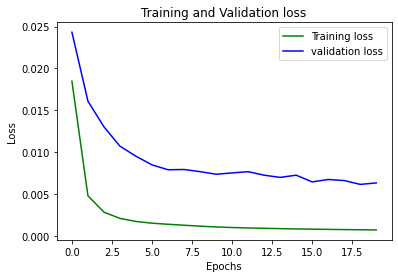

In [ ]:

history=H3
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
####################################################### Autoencoder Evaluation ################################

In [ ]:
def calculate_losses(x,preds):
    losses=np.zeros(len(x))
    for i in range(len(x)):
        losses[i]=((preds[i] - x[i]) ** 2).mean(axis=None)

    return losses

# We set the threshold equal to the training loss of the autoencoder
threshold=history.history["loss"][-1]
training_set_predictions=model.predict(trainX)
test_losses=calculate_losses(trainX,training_set_predictions)
training_set_predictions=np.zeros(len(test_losses))
training_set_predictions[np.where(test_losses>threshold)]=1

accuracy=accuracy_score(y0,training_set_predictions)
recall=recall_score(y0,training_set_predictions)
precision=precision_score(y0,training_set_predictions)
f1=f1_score(y0,training_set_predictions)
f1=f1_score(y0,training_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0,training_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))
testing_set_predictions=model.predict(testT)
test_losses=calculate_losses(testT,testing_set_predictions)
testing_set_predictions=np.zeros(len(test_losses))
testing_set_predictions[np.where(test_losses>threshold)]=1

accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,testing_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

Performance over the training data set 

Accuracy : 0.9147118827050241 , Recall : 0.9699812382739212 , Precision : 0.8635770036747957 , F1 : 0.9136917194177564, FAR : 0.13340659014299927 

Performance over the testing data set 

Accuracy : 0.8797852992059619 , Recall : 0.8922309670381049 , Precision : 0.896141504265477 , F1 : 0.894181960171808, FAR : 0.13666323377960865 



In [ ]:
##############################################Saving the model all models except Convolutional 

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive')

from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.h5")
print("Saved model to disk")

# later...

Saved model to disk


In [ ]:
##################################################Loading all model except convolutional 

In [ ]:
# load json and create model
json_file = open('/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')# Contractive model its contractive_loss

threshold=0.00161
testing_set_predictions=loaded_model.predict(testT)
test_losses=calculate_losses(testT,testing_set_predictions)
testing_set_predictions=np.zeros(len(test_losses))
testing_set_predictions[np.where(test_losses>threshold)]=1

accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,testing_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR :{}\n".format(accuracy,recall,precision,f1,FAR ))

training_set_predictions=loaded_model.predict(trainX)
test_losses=calculate_losses(trainX,training_set_predictions)
training_set_predictions=np.zeros(len(test_losses))
training_set_predictions[np.where(test_losses>threshold)]=1 

accuracy=accuracy_score(y0,training_set_predictions)
recall=recall_score(y0,training_set_predictions)
precision=precision_score(y0,training_set_predictions)
f1=f1_score(y0,training_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0,training_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

Loaded model from disk
Performance over the testing data set 

Accuracy : 0.8798740185423413 , Recall : 0.8923868152419543 , Precision : 0.8961577588230691 , F1 : 0.8942683117288771, FAR :0.13666323377960865

Performance over the training data set 

Accuracy : 0.9146880680780802 , Recall : 0.9700324066177725 , Precision : 0.8635045473179175 , F1 : 0.91367386118095, FAR : 0.13349568626286326 



In [ ]:
#########################Saving Convolutional AE

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive')

# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/autoencoderNSL/2CAE_NSL.h5")
print("Saved model to disk")

# later...

Mounted at /content/gdrive


In [ ]:
#########################Loading  Convolutional AE

In [ ]:

threshold=0.0011
testing_set_predictions=loaded_model.predict(xin_test)
test_losses=calculate_losses(xin_test,testing_set_predictions)
testing_set_predictions=np.zeros(len(test_losses))
testing_set_predictions[np.where(test_losses>threshold)]=1

accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,testing_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR :{}\n".format(accuracy,recall,precision,f1,FAR ))
threshold=0.0012

training_set_predictions=loaded_model.predict(xin)
test_losses=calculate_losses(xin,training_set_predictions)
training_set_predictions=np.zeros(len(test_losses))
training_set_predictions[np.where(test_losses>threshold)]=1 

accuracy=accuracy_score(y0,training_set_predictions)
recall=recall_score(y0,training_set_predictions)
precision=precision_score(y0,training_set_predictions)
f1=f1_score(y0,training_set_predictions)
tn, fp, fn, tp=confusion_matrix(y0,training_set_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

Performance over the testing data set 

Accuracy : 0.8107172958346271 , Recall : 0.775033117743318 , Precision : 0.8781564541762317 , F1 : 0.82337845109483, FAR :0.14212152420185376

Performance over the training data set 

Accuracy : 0.9090519397013646 , Recall : 0.964267439877196 , Precision : 0.857929799535639 , F1 : 0.907995856320316, FAR : 0.13901964569443 



In [ ]:
####################################ROC Analysis 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc



In [ ]:
from keras.models import model_from_json
from google.colab import drive
#drive.mount('/content/gdrive')

def calculate_losses(x,preds):
    losses=np.zeros(len(x))
    for i in range(len(x)):
        losses[i]=((preds[i] - x[i]) ** 2).mean(axis=None)

    return losses


loaded_model=create_Convolutional_network()

# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2CAE_NSL.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')
threshold=0.0011  #0.0012 training
training_set_predictions=loaded_model.predict(xin_test)
test_losses=calculate_losses(xin_test,training_set_predictions)
CAE_predictions=np.zeros(len(test_losses))
CAE_predictions[np.where(test_losses>threshold)]=1 
caemodel=loaded_model
##########################

# load json and create model
json_file = open('/content/gdrive/My Drive/autoencoderNSL/2SAE_NSL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2SAE_NSL.h5")
print("Loaded model from disk")
saemodel=loaded_model
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')
threshold=0.00063
training_set_predictions=loaded_model.predict(testT)
test_losses=calculate_losses(testT,training_set_predictions)
SAE_predictions=np.zeros(len(test_losses))
SAE_predictions[np.where(test_losses>threshold)]=1 
##########################

# load json and create model
json_file = open('/content/gdrive/My Drive/autoencoderNSL/2SSAE_NSL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2SSAE_NSL.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')
threshold=0.00103
training_set_predictions=loaded_model.predict(testT)
test_losses=calculate_losses(testT,training_set_predictions)
SSAE_predictions=np.zeros(len(test_losses))
SSAE_predictions[np.where(test_losses>threshold)]=1 
##########################

# load json and create model
json_file = open('/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2DAE_NSL.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')
threshold=0.001610
training_set_predictions=loaded_model.predict(testT)
test_losses=calculate_losses(testT,training_set_predictions)
DAE_predictions=np.zeros(len(test_losses))
DAE_predictions[np.where(test_losses>threshold)]=1 
###############################################3

# load json and create model
json_file = open('/content/gdrive/My Drive/autoencoderNSL/2ContAE_NSL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/autoencoderNSL/2ContAE_NSL.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error')
threshold=0.000372
training_set_predictions=loaded_model.predict(testT)
test_losses=calculate_losses(testT,training_set_predictions)
ContAE_predictions=np.zeros(len(test_losses))
ContAE_predictions[np.where(test_losses>threshold)]=1 

build (None, 40, 8)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 1, 40, 8)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 1, 41, 1)          17        
_________________________________________________________________
lambda_13 (Lambda)           (None, 41, 1)             0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


In [ ]:
accuracy=accuracy_score(y0,SAE_predictions)
recall=recall_score(y0,SAE_predictions)
precision=precision_score(y0,SAE_predictions)
f1=f1_score(y0,SAE_predictions)
f1=f1_score(y0,SAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0,SAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0,SSAE_predictions)
recall=recall_score(y0,SSAE_predictions)
precision=precision_score(y0,SSAE_predictions)
f1=f1_score(y0,SSAE_predictions)
f1=f1_score(y0,SSAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0,SSAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0,DAE_predictions)
recall=recall_score(y0,DAE_predictions)
precision=precision_score(y0,DAE_predictions)
f1=f1_score(y0,DAE_predictions)
f1=f1_score(y0,DAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0,DAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0,ContAE_predictions)
recall=recall_score(y0,ContAE_predictions)
precision=precision_score(y0,ContAE_predictions)
f1=f1_score(y0,ContAE_predictions)
f1=f1_score(y0,ContAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0,ContAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0,CAE_predictions)
recall=recall_score(y0,CAE_predictions)
precision=precision_score(y0,CAE_predictions)
f1=f1_score(y0,CAE_predictions)
f1=f1_score(y0,CAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0,CAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))


Performance over the training data set 

Accuracy : 0.8917069530772467 , Recall : 0.9834044004775712 , Precision : 0.8198532548417371 , F1 : 0.8942119792797544, FAR : 0.1881264570927936 

Performance over the training data set 

Accuracy : 0.904487469537123 , Recall : 0.9700153505031553 , Precision : 0.8469901408870223 , F1 : 0.9043378704999364, FAR : 0.15256225591375497 

Performance over the training data set 

Accuracy : 0.9146880680780802 , Recall : 0.9700324066177725 , Precision : 0.8635045473179175 , F1 : 0.91367386118095, FAR : 0.13349568626286326 

Performance over the training data set 

Accuracy : 0.8959856477181618 , Recall : 0.9726249360395702 , Precision : 0.8322023262262306 , F1 : 0.8969509173987243, FAR : 0.17073786436600685 

Performance over the training data set 

Accuracy : 0.9000976399704699 , Recall : 0.9709704929217124 , Precision : 0.8395098140419696 , F1 : 0.9004674116781739, FAR : 0.16160551207994892 



In [ ]:
accuracy=accuracy_score(y0_test,SAE_predictions)
recall=recall_score(y0_test,SAE_predictions)
precision=precision_score(y0_test,SAE_predictions)
f1=f1_score(y0_test,SAE_predictions)
f1=f1_score(y0_test,SAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,SAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0_test,SSAE_predictions)
recall=recall_score(y0_test,SSAE_predictions)
precision=precision_score(y0_test,SSAE_predictions)
f1=f1_score(y0_test,SSAE_predictions)
f1=f1_score(y0_test,SSAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,SSAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0_test,DAE_predictions)
recall=recall_score(y0_test,DAE_predictions)
precision=precision_score(y0_test,DAE_predictions)
f1=f1_score(y0_test,DAE_predictions)
f1=f1_score(y0_test,DAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,DAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0_test,ContAE_predictions)
recall=recall_score(y0_test,ContAE_predictions)
precision=precision_score(y0_test,ContAE_predictions)
f1=f1_score(y0_test,ContAE_predictions)
f1=f1_score(y0_test,ContAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,ContAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))

accuracy=accuracy_score(y0_test,CAE_predictions)
recall=recall_score(y0_test,CAE_predictions)
precision=precision_score(y0_test,CAE_predictions)
f1=f1_score(y0_test,CAE_predictions)
f1=f1_score(y0_test,CAE_predictions)
tn, fp, fn, tp=confusion_matrix(y0_test,CAE_predictions).ravel()
FAR=fp/(fp+tn)
print("Performance over the training data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}, FAR : {} \n".format(accuracy,recall,precision,f1,FAR ))


Performance over the training data set 

Accuracy : 0.8536130949740496 , Recall : 0.8602041611470428 , Precision : 0.8799521721801514 , F1 : 0.8699661123808022, FAR : 0.15509783728115345 

Performance over the training data set 

Accuracy : 0.8692276981768177 , Recall : 0.8634769734278812 , Precision : 0.9025820640221552 , F1 : 0.8825965750696934, FAR : 0.1231719876416066 

Performance over the training data set 

Accuracy : 0.8798740185423413 , Recall : 0.8923868152419543 , Precision : 0.8961577588230691 , F1 : 0.8942683117288771, FAR : 0.13666323377960865 

Performance over the training data set 

Accuracy : 0.8524597436011179 , Recall : 0.851632509935323 , Precision : 0.8848676220548943 , F1 : 0.8679320203303685, FAR : 0.14644696189495365 

Performance over the training data set 

Accuracy : 0.8107172958346271 , Recall : 0.775033117743318 , Precision : 0.8781564541762317 , F1 : 0.82337845109483, FAR : 0.14212152420185376 



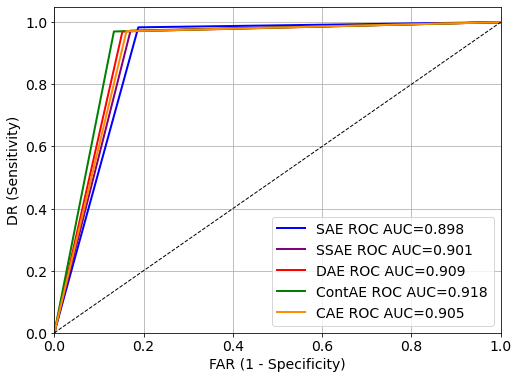

In [ ]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y0, SAE_predictions)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SAE ROC AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y0, SSAE_predictions)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='SSAE ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y0,DAE_predictions  )
plt.plot(fpr, tpr, color='red', lw=2,
         label='DAE ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y0,ContAE_predictions )
plt.plot(fpr, tpr, color='green', lw=2,
         label='ContAE ROC AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y0, CAE_predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='CAE ROC AUC={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FAR (1 - Specificity)')
plt.ylabel('DR (Sensitivity)')
plt.show()

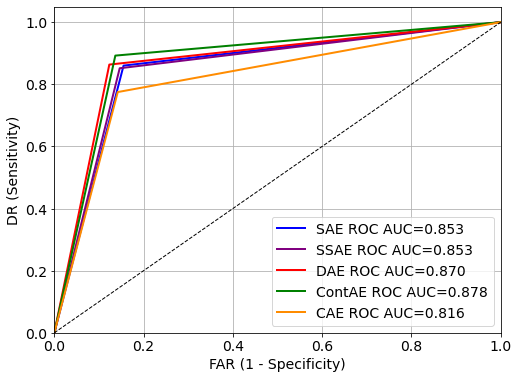

In [ ]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y0_test, SAE_predictions)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SAE ROC AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y0_test, SSAE_predictions)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='SSAE ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y0_test,DAE_predictions  )
plt.plot(fpr, tpr, color='red', lw=2,
         label='DAE ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y0_test,ContAE_predictions )
plt.plot(fpr, tpr, color='green', lw=2,
         label='ContAE ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y0_test, CAE_predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='CAE ROC AUC={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FAR (1 - Specificity)')
plt.ylabel('DR (Sensitivity)')
plt.show()

In [ ]:
############################PR Curve

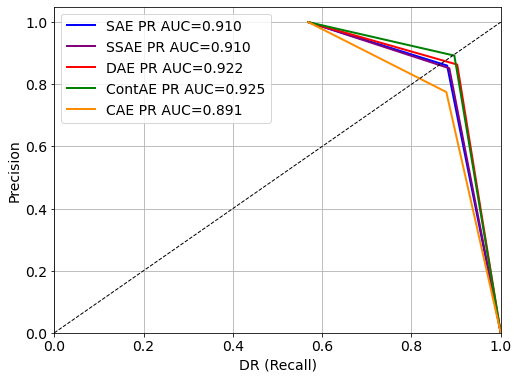

In [ ]:
from sklearn.metrics import precision_recall_curve,auc
def PR_curve_and_score(y_test, pred_proba):
    precision, recall, _ = precision_recall_curve(y_test.ravel(), pred_proba.ravel())
    PR_auc = auc(recall,precision)
    return precision, recall, PR_auc

plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, roc_auc = PR_curve_and_score(y0_test, SAE_predictions)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SAE PR AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = PR_curve_and_score(y0_test, SSAE_predictions)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='SSAE PR AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = PR_curve_and_score(y0_test,DAE_predictions  )
plt.plot(fpr, tpr, color='red', lw=2,
         label='DAE PR AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = PR_curve_and_score(y0_test,ContAE_predictions )
plt.plot(fpr, tpr, color='green', lw=2,
         label='ContAE PR AUC={0:.3f}'.format(roc_auc))

fpr, tpr, roc_auc = PR_curve_and_score(y0_test, CAE_predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='CAE PR AUC={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.legend(loc="upper left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('DR (Recall)')
plt.ylabel('Precision')
plt.show()

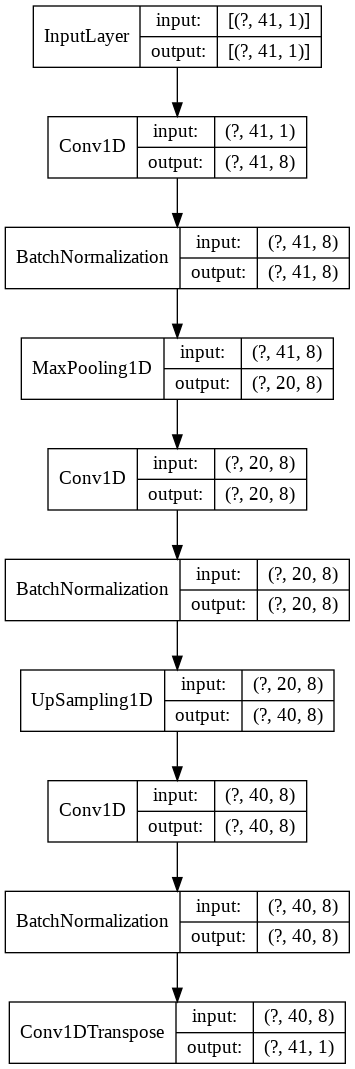

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(caemodel, to_file='model_plot.png', show_shapes=True, show_layer_names=False)


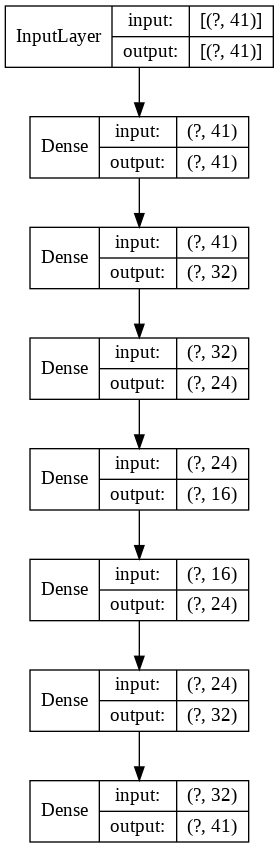

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(saemodel, to_file='model_plot.png', show_shapes=True, show_layer_names=False)
